In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import lightgbm as lgb

In [2]:
df_train = pd.read_csv('../data/Train.csv')
df_test = pd.read_csv('../data/Test.csv')
df_riders = pd.read_csv('../data/Riders.csv')

Check for the distribution of answers amongst different platform types

In [3]:
plat1 = df_train['Time from Pickup to Arrival'].loc[df_train['Platform Type'] == 1]
plat2 = df_train['Time from Pickup to Arrival'].loc[df_train['Platform Type'] == 2]
plat3 = df_train['Time from Pickup to Arrival'].loc[df_train['Platform Type'] == 3]
plat4 = df_train['Time from Pickup to Arrival'].loc[df_train['Platform Type'] == 4]

In [6]:
pd.DataFrame({'plat1': plat1, 'plat2': plat2, 'plat3': plat3, 'plat4': plat4}).describe()

,plat1,plat2,plat3,plat4
count,2147.000000,980.000000,18054.000000,20.000000
mean,1572.799721,1540.861224,1555.773402,1675.150000
std,874.175365,935.371447,1002.662582,942.385008
min,3.000000,9.000000,1.000000,356.000000
25%,945.000000,901.000000,870.000000,1108.000000
50%,1379.000000,1343.500000,1369.500000,1539.000000
75%,1994.000000,1941.250000,2050.000000,2445.750000
max,7277.000000,7883.000000,7714.000000,3568.000000


Distribution for platform 4 is very different so we will train these models by platforms

In [4]:
df_train.head(9)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214
5,Order_No_7408,User_Id_1342,Bike,3,Business,14,5,3:07:35 PM,14,5,...,4:23:41 PM,9,27.2,NaN,-1.302583,36.767081,-1.257309,36.806008,Rider_Id_124,3191
6,Order_No_22680,User_Id_2803,Bike,3,Business,9,5,9:33:45 AM,9,5,...,10:19:45 AM,5,20.3,NaN,-1.279395,36.825364,-1.276574,36.851365,Rider_Id_114,1380
7,Order_No_21578,User_Id_1075,Bike,3,Business,11,1,2:13:01 PM,11,1,...,2:33:26 PM,3,28.7,NaN,-1.252796,36.800313,-1.255189,36.782203,Rider_Id_913,646
8,Order_No_5234,User_Id_733,Bike,3,Business,30,2,11:10:44 AM,30,2,...,1:19:35 PM,9,NaN,NaN,-1.255189,36.782203,-1.300255,36.825657,Rider_Id_394,3398


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time   

In [6]:
df_train.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


In [11]:
print(f"There are { df_train['User Id'].nunique() } users (customers) on the platform")
print(f"There are {df_train['Rider Id'].nunique()} riders on the platform")

There are 3186 users (customers) on the platform
There are 924 riders on the platform


In [17]:
train_users_diff = set(df_train['User Id']) - set(df_test['User Id'])
test_users_diff = set(df_test['User Id']) - set(df_train['User Id'])
print(f"There are { len(train_users_diff) } users in the train set that are not in the test set")
print(f"There are { len(test_users_diff) } users in the test set that are not in the train set")

There are 2165 users in the train set that are not in the test set
There are 596 users in the test set that are not in the train set


In [19]:
df_riders.head(7)

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466
3,Rider_Id_753,314,980,12.5,75
4,Rider_Id_335,536,1113,13.7,156
5,Rider_Id_720,2608,1798,13.2,504
6,Rider_Id_95,3464,1304,13.4,950


In [21]:
df_riders["Rider Id"].nunique()

960

In [27]:
def merge_df(df_1, df_2):
    df = df_1.merge(df_2, on=['Rider Id'])
    return df

df_train = merge_df(df_train, df_riders)
df_test = merge_df(df_test, df_riders)

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time   

Using the famous reduce_mem_usage function did not work. It increases it instead

In [28]:
df_train.to_csv("../data/df_train.csv")
df_test.to_csv("../data/df_test.csv")

Analyse the model that gave me 650 rmse

In [37]:
lgb_model = pickle.load(open(f"../output/models/lgb_models_v8.pkl", "rb"))

In [38]:
lgb_model[0][0].params

{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 20,
 'max_depth': 20,
 'max_bin': 255,
 'reg_alpha': 0.1,
 'reg_lambda': 0.3,
 'verbose': -1,
 'seed': None,
 'bagging_freq': 5,
 'bagging_fraction': 0.7,
 'feature_fraction': 0.9,
 'metric': 'rmse'}

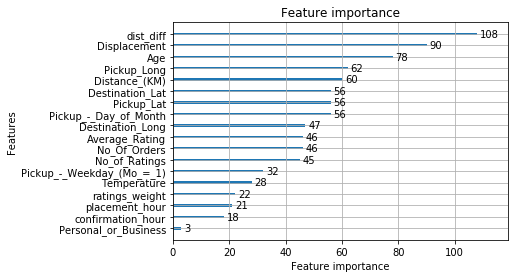

In [39]:
lgb.plot_importance(lgb_model[0][0])

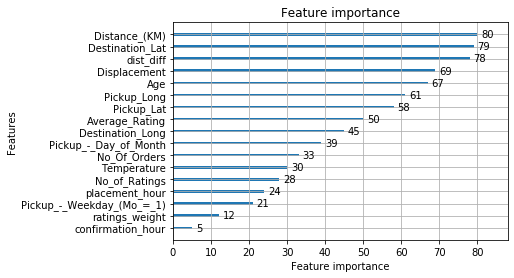

In [40]:
lgb.plot_importance(lgb_model[0][1])

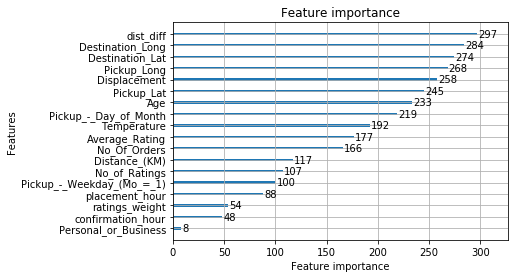

In [41]:
lgb.plot_importance(lgb_model[0][2])

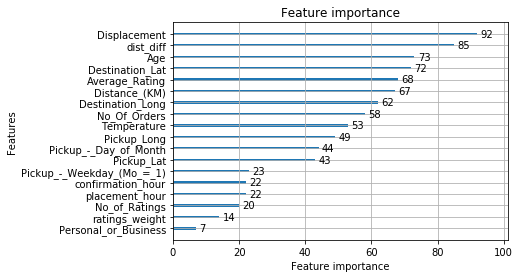

In [42]:
lgb.plot_importance(lgb_model[0][3])